## Análisis detallado de un conjunto de datos de reseñas de películas.
Utilizaremos técnicas de procesamiento de lenguaje natural (NLP) y análisis de texto para explorar y entender las opiniones expresadas en estas reseñas.

# Índice
0. Instalar librerías
1. Cargar el dataset
2. Análisis exploratorio de los datos
3. Preprocesamiento de los datos
4. Wordclouds
5. Word Embeddings
6. Análisis

## 0. Instalar librerías

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional

## 1. Cargar el dataset

Este es un conjunto de datos para la clasificación de sentimientos binarios. Proporciona un conjunto de 25.000 reseñas de películas muy polarizadas para formación y 25.000 para pruebas.


In [38]:
# Cargar el conjunto de datos de reseñas de películas
data = pd.read_csv("IMDB Dataset.csv")

In [39]:
# Obtener y mostrar el número de filas y columnas
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 50000 rows and 2 columns


In [40]:
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. Análisis exploratorio de datos

En este apartado se realizará un análisis exploratorio de los datos. Se mostrará la distribución de las clases por categoría y veremos las nubes de palabras para cada clase.

In [41]:
# Obtener información general sobre el dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [42]:
print("\nDistribución de las etiquetas de sentimiento:")
print(data['sentiment'].value_counts())


Distribución de las etiquetas de sentimiento:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


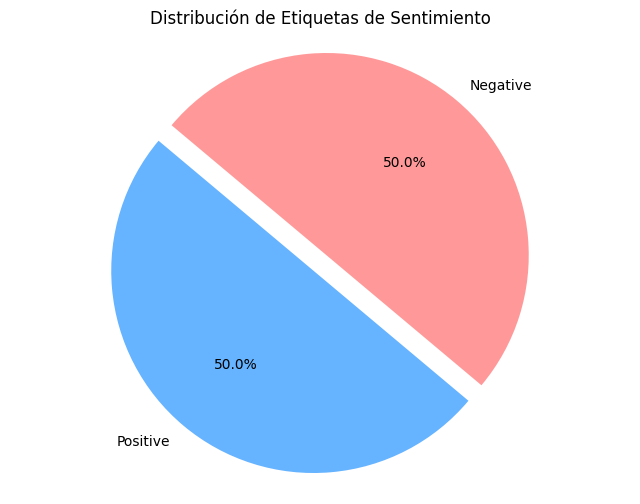

In [43]:
# Calcular el número de muestras positivas y negativas
num_positive = data['sentiment'].value_counts()['positive']
num_negative = data['sentiment'].value_counts()['negative']

# Calcular los porcentajes
total = num_positive + num_negative
percentage_positive = (num_positive / total) * 100
percentage_negative = (num_negative / total) * 100

# Crear el gráfico de pastel
labels = ['Positive', 'Negative']
sizes = [percentage_positive, percentage_negative]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Etiquetas de Sentimiento')
plt.axis('equal') 
plt.show()

## 3. Preprocesamiento de los datos

En este paso, realizaremos tareas como la eliminación de caracteres especiales, la tokenización, la eliminación de stopwords y la lematización. Estas técnicas nos ayudarán a reducir el ruido en los datos y a extraer las características más relevantes de los textos, lo que facilitará el entrenamiento de nuestros modelos.

In [44]:
def clean_text(review):
    # Convertir a string
    review = str(review)

    # Eliminar URLs
    review = re.sub(r'http\S+', '', review)
    
    # Eliminar etiquetas HTML
    review = re.sub(r'<.*?>', '', review)

    # Eliminar menciones y hashtags
    review = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', review)

    # Eliminar caracteres especiales, números y signos de puntuación
    review = re.sub(r'[^A-Za-z\s]', '', review)

    # Eliminar indicador de 'RT' (Rereview)
    review = re.sub(r'\bRT\b', '', review)

    # Reemplazar contracciones
    review = re.sub(r"won\'t", "would not", review)
    review = re.sub(r"im", "i am", review)
    review = re.sub(r"Im", "I am", review)
    review = re.sub(r"can\'t", "can not", review)
    review = re.sub(r"don\'t", "do not", review)
    review = re.sub(r"shouldn\'t", "should not", review)
    review = re.sub(r"needn\'t", "need not", review)
    review = re.sub(r"hasn\'t", "has not", review)
    review = re.sub(r"haven\'t", "have not", review)
    review = re.sub(r"weren\'t", "were not", review)
    review = re.sub(r"mightn\'t", "might not", review)
    review = re.sub(r"didn\'t", "did not", review)
    review = re.sub(r"n\'t", " not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'t", " not",review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)

    # Eliminar caracteres especiales
    review = re.sub(r'[!]+' , '!' , review)
    review = re.sub(r'[?]+' , '?' , review)
    review = re.sub(r'[.]+' , '.' , review)
    review = re.sub(r'[@]+' , '@' , review)
    review = re.sub(r'unk' , ' ' , review)
    review = re.sub('\n', '', review)

    # Convertir a minúsculas y eliminar espacios extra
    review = review.lower()
    review = re.sub(r'[ ]+' , ' ' , review)

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review)
    review = ' '.join([word for word in review_tokens if word not in stop_words])

    # Lematización
    # En el contexto de la limpieza de reseñas de películas, 
    # la lematización puede no ser tan crucial como en otros 
    # casos. La razón es que las reseñas de películas suelen 
    # ser menos formales y más variadas en términos de 
    # vocabulario, por lo que la lematización puede no tener 
    # un impacto significativo en la comprensión del texto.

    return review

In [45]:
# Plot some stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [46]:
# Dividir los datos en características (X) y etiquetas (y)
X = data['review']
y = data['sentiment']

# Dividir los datos en conjuntos de entrenamiento y prueba, asegurando el balanceo de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)


In [47]:
# Combinar X_train y y_train en un DataFrame para el preprocesamiento
df_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})

# Combinar X_test y y_test en un DataFrame para el preprocesamiento
df_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})

In [48]:
# Mostrar la distribución de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en el conjunto de entrenamiento:")
print(df_train['sentiment'].value_counts())

Distribución de clases en el conjunto de entrenamiento:
sentiment
positive    12500
negative    12500
Name: count, dtype: int64


In [49]:
print("Distribución de clases en el conjunto de prueba:")
print(df_test['sentiment'].value_counts())

Distribución de clases en el conjunto de prueba:
sentiment
negative    12500
positive    12500
Name: count, dtype: int64


In [50]:
# Aplicar la función clean_text al conjunto de datos de entrenamiento y prueba
df_train['clean_review'] = df_train['review'].apply(clean_text)
df_test['clean_review'] = df_test['review'].apply(clean_text)

In [51]:
# Mostrar algunas reseñas limpiadas como ejemplo
print("Ejemplo de reseñas limpiadas en el conjunto de entrenamiento:")
print(df_train[['review', 'clean_review']].head(2))


Ejemplo de reseñas limpiadas en el conjunto de entrenamiento:
                                                  review  \
3055   Trio's vignettes were insightful and quite enj...   
47326  I had never heard of this one before the owner...   

                                            clean_review  
3055   trios vignettes insightful quite enjoyable cur...  
47326  never heard one owner local dvd rental outlet ...  


In [52]:
# Guardar los datos limpiados en archivos CSV
df_train.to_csv('df_train_clean.csv', index=False)
df_test.to_csv('df_test_clean.csv', index=False)

## 4. Wordclouds

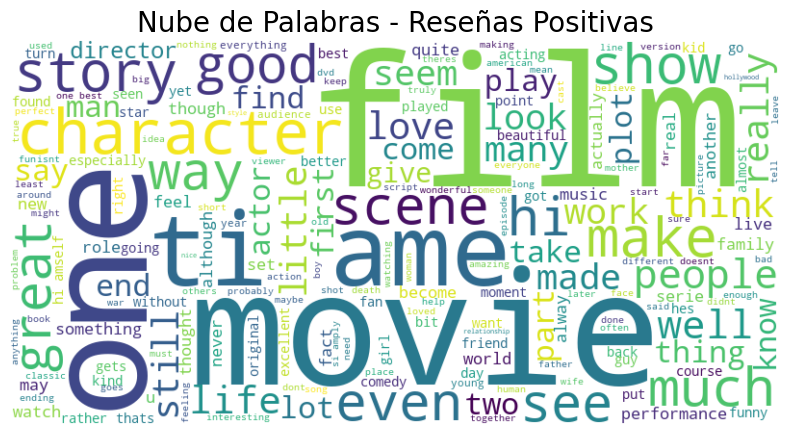

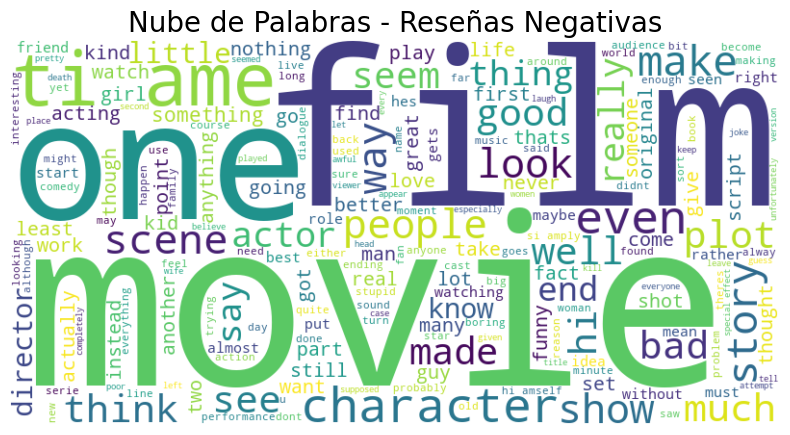

In [53]:
# Crear una función para generar una nube de palabras
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=20)
    plt.axis('off')
    plt.show()

# Generar nubes de palabras para reseñas positivas
positive_reviews = df_train[df_train['sentiment'] == 'positive']['clean_review'].str.cat(sep=' ')
generate_wordcloud(positive_reviews, 'Nube de Palabras - Reseñas Positivas')

# Generar nubes de palabras para reseñas negativas
negative_reviews = df_train[df_train['sentiment'] == 'negative']['clean_review'].str.cat(sep=' ')
generate_wordcloud(negative_reviews, 'Nube de Palabras - Reseñas Negativas')

## 5. Word Embeddings
Utilizaremos Gensim para crear y entrenar un modelo Word2Vec en las reseñas de películas. Este proceso nos ayudará a convertir las palabras en vectores de manera que las relaciones semánticas entre las palabras se conserven.

### 5.1. Entrenar un Modelo Word2Vec con Gensim
Necesitamos asegurarnos de que todas las reseñas estén tokenizadas. Luego, utilizaremos estas listas de palabras para entrenar el modelo Word2Vec.

In [54]:
# Tokenizar reseñas limpias
df_train['tokenized_review'] = df_train['clean_review'].apply(lambda x: x.split())

# Entrenar el modelo Word2Vec
model = Word2Vec(
    sentences=df_train['tokenized_review'],
    vector_size=100,  # Tamaño del vector de cada palabra
    window=10,        # Contexto de la ventana
    min_count=2,     # Ignorar palabras con frecuencia menor a 2
    workers=4        # Usar múltiples hilos
)

# Guardar el modelo entrenado
model.save("word2vec_model.w2v")

# Mostrar detalles del modelo
print(model)

Word2Vec<vocab=56301, vector_size=100, alpha=0.025>


### 5.2 Explorar Word Embeddings
Exploramos algunas características del modelo Word2Vec, como encontrar palabras similares a una palabra dada, o verificar la similitud entre dos palabras.

In [55]:
# Cargar el modelo guardado
model = Word2Vec.load("word2vec_model.w2v")

# Palabras más similares a 'good'
similar_words = model.wv.most_similar('good', topn=10)
print("Palabras similares a 'good':")
print(similar_words)

Palabras similares a 'good':
[('decent', 0.7375102639198303), ('great', 0.664667010307312), ('nice', 0.6609424948692322), ('bad', 0.6419739127159119), ('alright', 0.6365943551063538), ('fair', 0.6129032373428345), ('okay', 0.6072702407836914), ('fine', 0.5971166491508484), ('ok', 0.5945068597793579), ('average', 0.5805196762084961)]


In [56]:
# Verificar la similitud entre dos palabras
similarity = model.wv.similarity('good', 'worst')
print(f"Similitud entre 'good' y 'worst': {similarity}")

Similitud entre 'good' y 'worst': 0.230995774269104


In [57]:
# Mostrar el vector de una palabra específica
word_vector = model.wv['good']
print("Vector para 'good':")
print(word_vector)

Vector para 'good':
[ 0.31318802 -0.23860994 -1.7450644  -0.03931707  0.7182957   0.14192955
  0.33706856 -0.0634765   1.3401219  -2.8397622  -0.8155448  -2.2716005
  1.9867376  -1.4133569  -2.0043328  -2.2532938  -0.7151163  -1.4457978
  0.77502906 -1.1919171  -1.478626   -1.8628837  -0.03660774  1.1251388
 -0.86727446 -1.4058172   0.4988216  -2.5773015  -0.07198793 -1.3729237
 -0.50946975 -1.7162403  -0.6100936   1.9170256  -0.88660306  1.9646981
  0.4555005  -1.6226286  -0.6277259  -0.17152885  2.1527643   0.71938545
  0.25012505 -0.13370767 -0.6675311   1.0113763  -0.3641086   0.33864906
  1.8024497  -1.2800214   0.70647925 -0.07830454  1.468806    3.072903
  0.23157108  1.3945713   4.995114    0.7408922   1.0224583   1.7593241
  2.3768167  -1.0756204   4.694395    0.4216206   2.4375918   0.89972854
 -0.2757634   0.86996007 -0.4901446  -0.6644572   0.3836154  -0.06218961
  1.4246895   0.20418452 -0.9344041   1.9476618  -0.04690828  1.9958489
  0.7277883  -0.68350875 -2.7462397   0.

### 5.3 Word2Vec y GloVe

In [58]:
# Preprocess texts: tokenize and clean
texts = df_train['clean_review'].apply(clean_text).tolist()

# Train Word2Vec model
model_w2v = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=1)
model_w2v.save("word2vec.model")

## 6. Análisis de reviews
En esta sección, implementaremos un modelo de red neuronal convolucional (CNN). 

In [59]:
# Filtrar el DataFrame para contener solo las clases 'Positive' y 'Negative'
df_train = df_train[df_train['sentiment'].isin(['positive', 'negative'])]
df_test = df_test[df_test['sentiment'].isin(['positive', 'negative'])]

# Mapear las etiquetas a valores numéricos
df_train['sentiment'] = df_train['sentiment'].map({'positive': 1, 'negative': 0})  # Binary encoding
df_test['sentiment'] = df_test['sentiment'].map({'positive': 1, 'negative': 0})

# Asignar la variable a predecir 'sentiment' como 'y'
y_train = df_train['sentiment'].astype(int).values
y_test = df_test['sentiment'].astype(int).values

In [60]:
# Tokenizamos los textos y los convertimos a secuencias (asignamos X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_review'].values)
sequences_train = tokenizer.texts_to_sequences(df_train['clean_review'].values)
sequences_test = tokenizer.texts_to_sequences(df_test['clean_review'].values)

X_train = pad_sequences(sequences_train, maxlen=100)
X_test = pad_sequences(sequences_test, maxlen=100)

print('Preprocessed text:', df_train['clean_review'].values[100])
print('\nTokenized text:', sequences_train[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

Preprocessed text: saw film via one actors agents surely conforms great deal comes sth australia terms overall tone rightly dark moodyi thought little boy film excellent mostly kid actors hammed embarrassing case really good terms surrealism thingy mentioned jingo well think film plain weird real weirdo film weirdo locations storyline weird stuff going whole ti ame good weird opposed badits hard think movies like like cars ate paris maybe like repulsion actually think like hammer movie certainly interesting mind working behind itjingo question also title modern love anyone also jingo mean god forsaken talking australia hmmm curious

Tokenized text: [110, 2, 2402, 3, 62, 3420, 1210, 42256, 18, 660, 159, 56666, 2787, 1181, 408, 1125, 6689, 335, 56667, 98, 41, 316, 2, 202, 520, 427, 62, 24824, 2041, 312, 10, 6, 1181, 8181, 16984, 922, 42257, 15, 30, 2, 908, 818, 57, 8994, 2, 8994, 1625, 615, 818, 404, 72, 108, 5, 7, 6, 818, 3314, 27225, 155, 30, 24, 4, 4, 1772, 8502, 1282, 179, 4, 13748, 

In [61]:
# Preparar la matriz de embeddings
word_vectors = model_w2v.wv
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors.get_vector(word)

embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
# Definir el modelo
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])

c:\Users\yera_\Documents\Areas\En proceso\Qualentum-Proyectos\Sprint 2\Lab 5\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4970 - loss: 0.6930 - val_accuracy: 0.4908 - val_loss: 0.6923
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.6881 - val_accuracy: 0.4916 - val_loss: 0.6921
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5213 - loss: 0.6843 - val_accuracy: 0.5188 - val_loss: 0.6919
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 0.6815 - val_accuracy: 0.5190 - val_loss: 0.6923
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5220 - loss: 0.6794 - val_accuracy: 0.5190 - val_loss: 0.6929
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5222 - loss: 0.6780 - val_accuracy: 0.5190 - val_loss: 0.6934
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5299 - loss: 0.6752 - val_accuracy: 0.4920 - val_loss: 0.6943
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5301 - loss: 0.6734 - val_accuracy: 0.

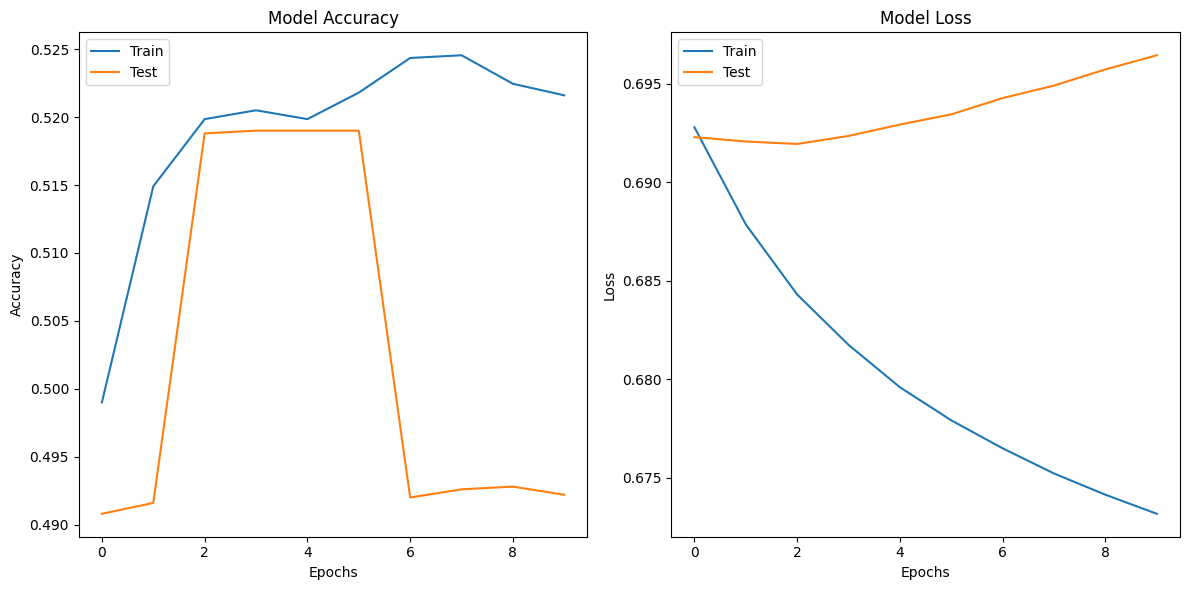

In [65]:
# Gráfica de precisión del modelo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
# Gráfica de pérdida del modelo
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step


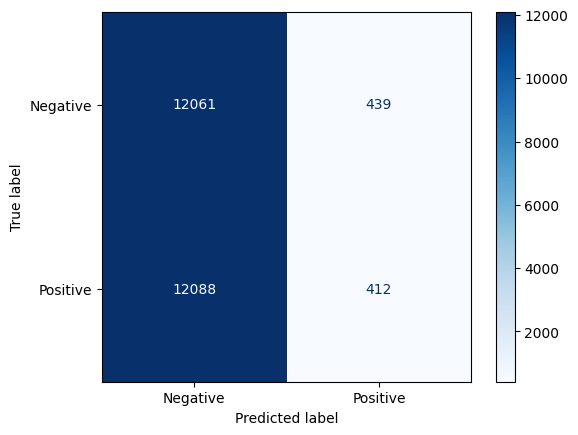

In [66]:
# Evaluar el modelo en los datos de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Mejoras

In [67]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional, GlobalMaxPooling1D

model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

c:\Users\yera_\Documents\Areas\En proceso\Qualentum-Proyectos\Sprint 2\Lab 5\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [68]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [69]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.4975 - loss: 0.6933 - val_accuracy: 0.5204 - val_loss: 0.6914
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.5141 - loss: 0.6922 - val_accuracy: 0.5200 - val_loss: 0.6908
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.5093 - loss: 0.6919 - val_accuracy: 0.5214 - val_loss: 0.6908
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.5064 - loss: 0.6917 - val_accuracy: 0.5202 - val_loss: 0.6908
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.5141 - loss: 0.6914 - val_accuracy: 0.4962 - val_loss: 0.6910


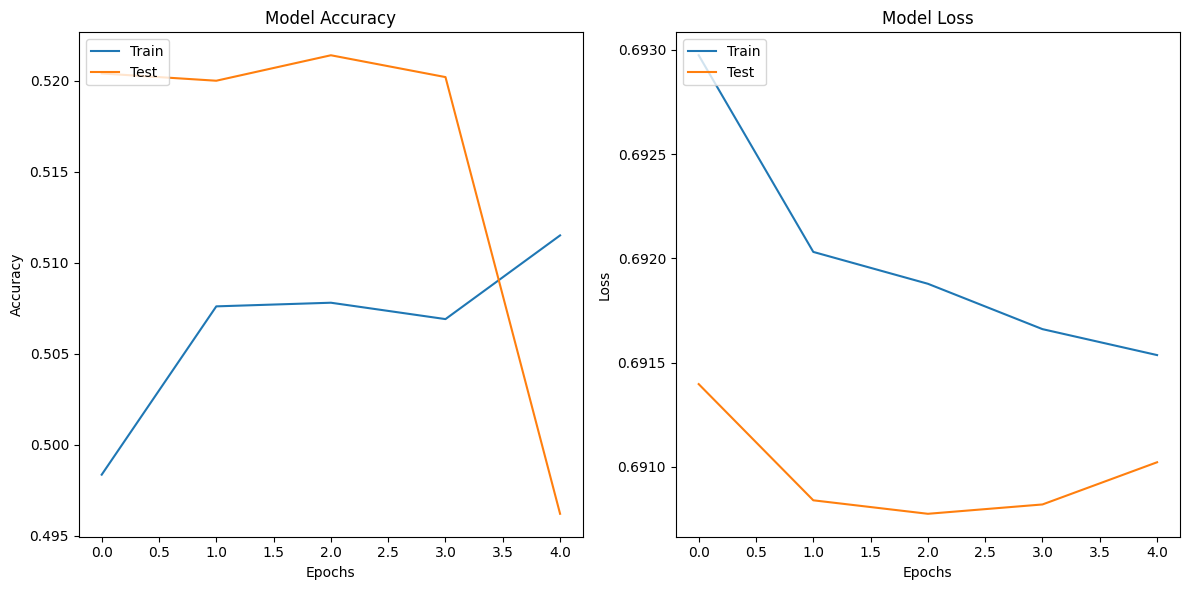

In [70]:
# Graficar la precisión y la pérdida del modelo mejorado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
# Gráfica de pérdida del modelo
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


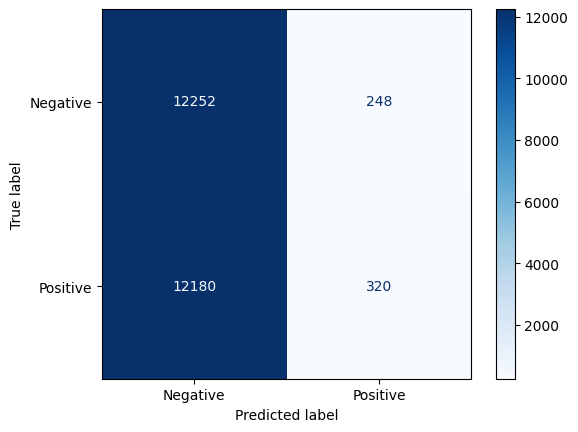

In [71]:
# Evaluar el modelo en los datos de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular y mostrar la matriz de confusión del modelo mejorado
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()